Para un gimnasio que cuenta con 10 tipos de máquinas distintas, cada una repetida varias veces, se plantea llevar a cabo un análisis de colas con el objetivo de identificar las máquinas que experimentan una mayor demanda. Este análisis permitirá determinar en qué máquinas se requiere una mayor capacidad y, por ende, podría ser necesario considerar inversiones adicionales para satisfacer eficientemente las necesidades de los usuarios.

Al evaluar la demanda a través de un análisis de colas, el gimnasio podrá obtener insights sobre la utilización de cada tipo de máquina, identificando aquellas que registran periodos de alta concurrencia. Este enfoque analítico proporcionará una base sólida para la toma de decisiones estratégicas en términos de inversiones, permitiendo al gimnasio optimizar la distribución de sus recursos y mejorar la experiencia general de los usuarios al asegurar un acceso más eficiente a las máquinas más demandadas.

In [26]:
import ciw
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import expon, poisson

### Inventario de maquinaria

In [2]:
data = {
    'Maquinaria': ['Banco de press de banca', 'Máquina de sentadillas', 'Prensa de piernas', 
                   'Máquina de curl de bíceps', 'Máquina de extensiones de tríceps', 
                   'Máquina de pull-ups', 'Máquina de hombros', 'Polea alta para espalda', 
                   'Máquina de abdominales', 'Máquina de elevación de pantorrillas'],
    'Usuarios_por_Hora': [1, 2, 4, 3, 3, 2, 2, 1, 1, 1], 
    'Tiempo_de_Uso_por_Usuario (min)': [10, 13, 15, 10, 10, 15, 15, 10, 5, 15], 
    'Cantidad_de_Maquinas': [3, 2, 3, 4, 3, 3, 4, 5, 6, 3]
}

maquinas_df = pd.DataFrame(data)
maquinas_df['Tiempo_de_Uso_por_Usuario (hs)'] = maquinas_df['Tiempo_de_Uso_por_Usuario (min)']/60
maquinas_df

,Maquinaria,Usuarios_por_Hora,Tiempo_de_Uso_por_Usuario (min),Cantidad_de_Maquinas,Tiempo_de_Uso_por_Usuario (hs)
0,Banco de press de banca,1,10,3,0.166667
1,Máquina de sentadillas,2,13,2,0.216667
2,Prensa de piernas,4,15,3,0.250000
3,Máquina de curl de bíceps,3,10,4,0.166667
4,Máquina de extensiones de tríceps,3,10,3,0.166667
5,Máquina de pull-ups,2,15,3,0.250000
6,Máquina de hombros,2,15,4,0.250000
7,Polea alta para espalda,1,10,5,0.166667
8,Máquina de abdominales,1,5,6,0.083333
9,Máquina de elevación de pantorrillas,1,15,3,0.250000


In [41]:
def plot_distributions(param, maquina):
    x_expon = np.linspace(0, 5 * param, 1000)
    y_expon = expon.pdf(x_expon, scale=param)

    x_poisson = np.arange(0, 20)
    y_poisson = poisson.pmf(x_poisson, mu=param)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.bar(x_poisson, y_poisson, label=f'Poisson(λ={param:.2f})', color='blue', alpha=0.7, width=0.8)
    plt.title(f'Función de Masa de Probabilidad - Poisson \n {maquina}')
    plt.xlabel('X')
    plt.ylabel('P(X)')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(x_expon, y_expon, label=f'Exponencial(λ={1/param:.2f})')
    plt.title(f'Función de Densidad de Probabilidad - Exponencial \n {maquina}')
    plt.xlabel('X')
    plt.ylabel('f(x)')
    plt.legend()

    plt.tight_layout()
    plt.show()



Para cada máquina, se simularán 3000 horas de uso de la misma, con la tasa de llegada y el tiempo medio de uso de cada una.

In [42]:
def simulate_colas(row):
    usuarios_por_hora = row['Usuarios_por_Hora']
    tiempo_de_uso = row['Tiempo_de_Uso_por_Usuario (hs)']

    plot_distributions(usuarios_por_hora, row['Maquinaria'])

    N = ciw.create_network(
        arrival_distributions=[ciw.dists.Exponential(rate=usuarios_por_hora)],
        service_distributions=[ciw.dists.Exponential(rate=1/tiempo_de_uso)],
        number_of_servers=[row['Cantidad_de_Maquinas']]
    )

    ciw.seed(1)
    Q = ciw.Simulation(N)
    Q.simulate_until_max_time(3000)
    data = Q.get_all_records()
    df = pd.DataFrame(data)

    df['Maquinaria'] = row['Maquinaria']
    
    return df

Se procede a unificar los resultados de todas las simulaciones

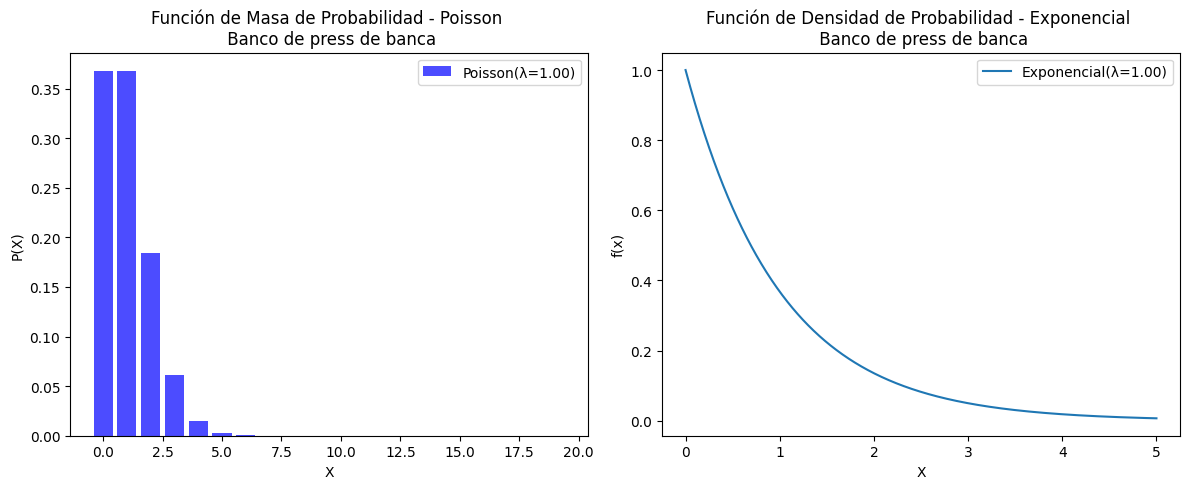

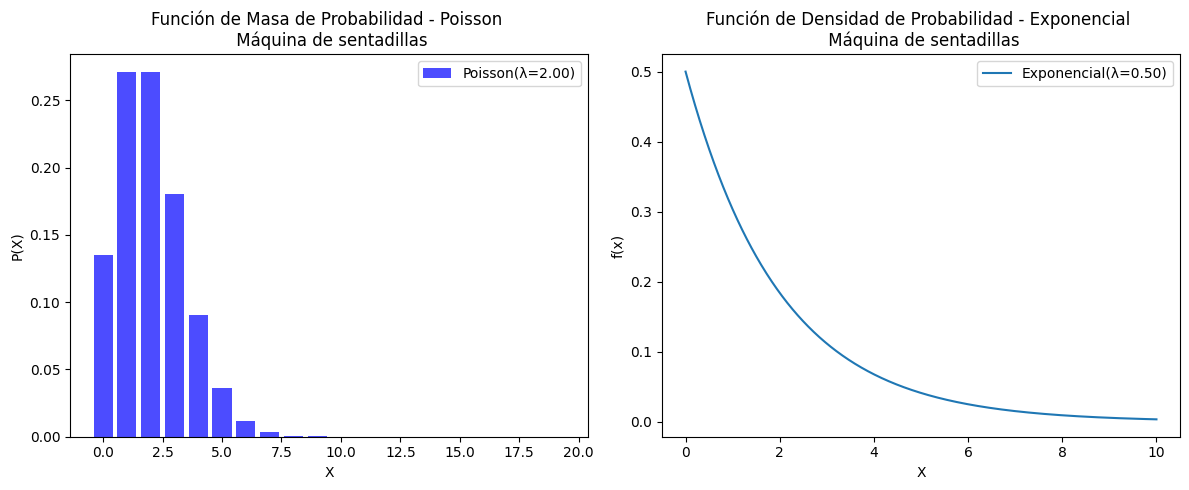

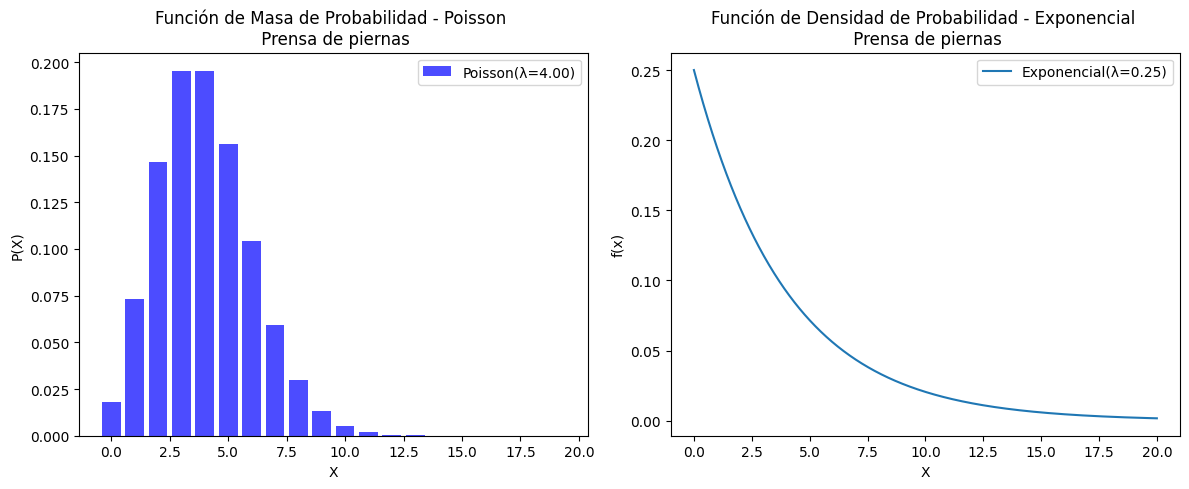

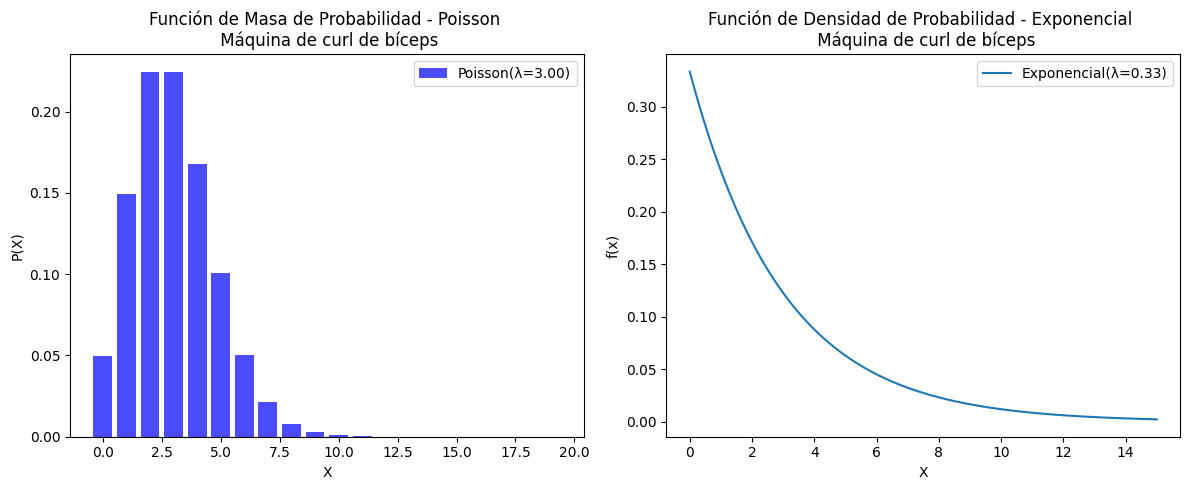

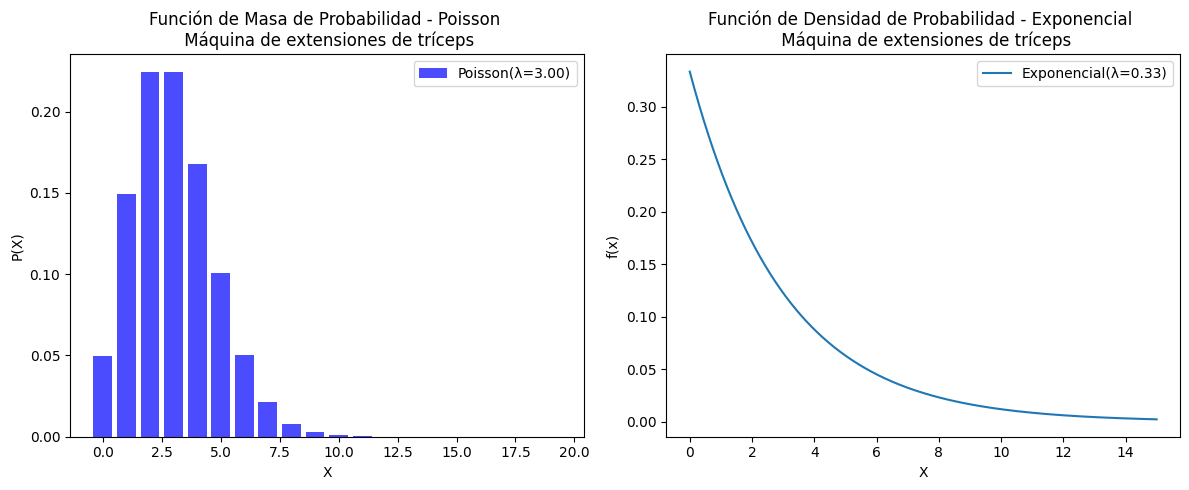

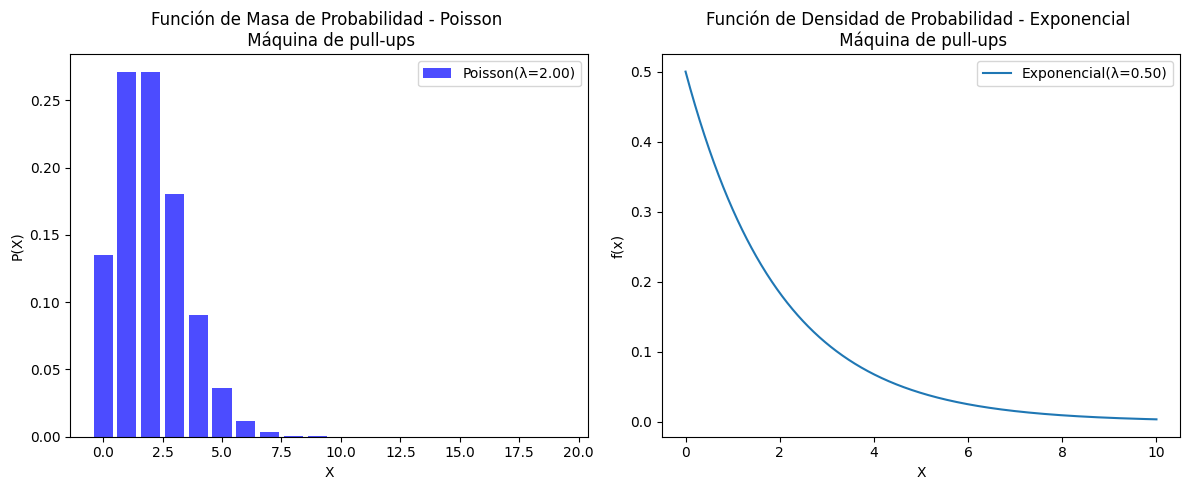

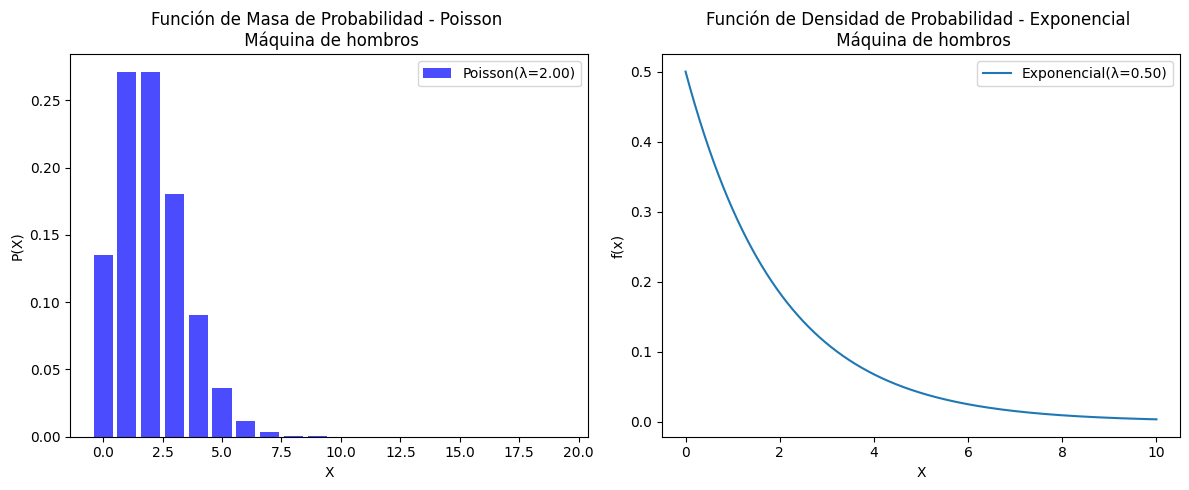

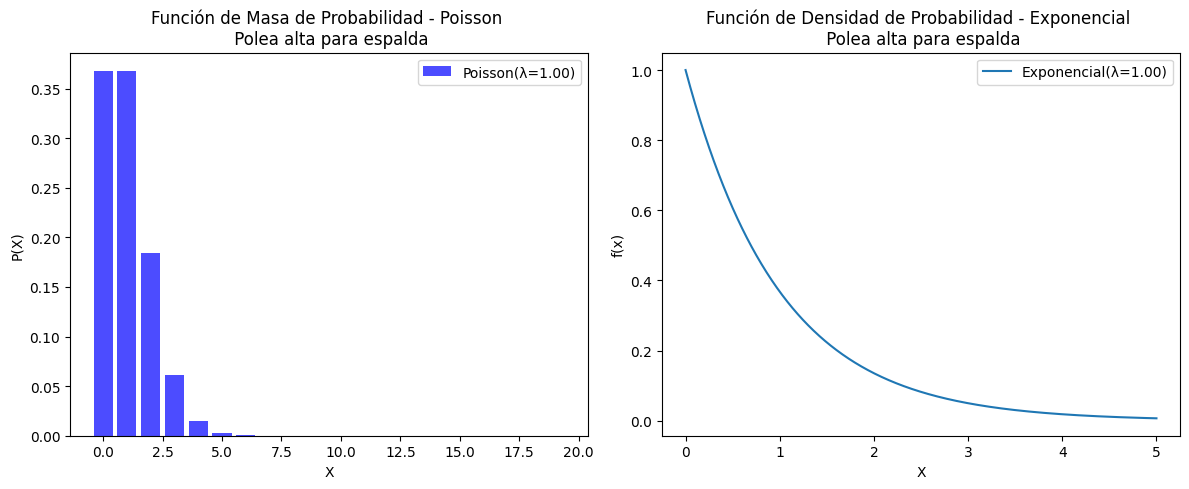

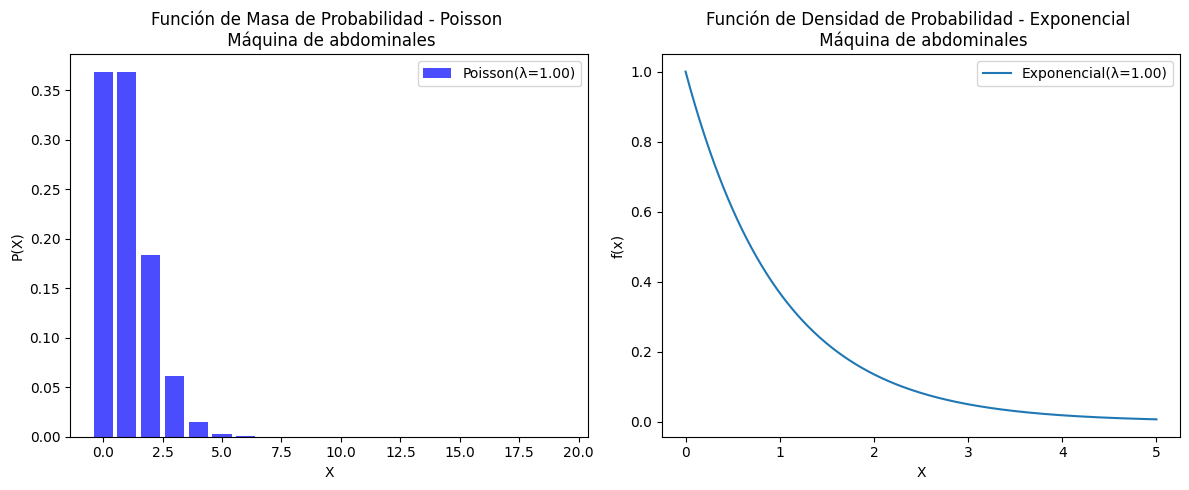

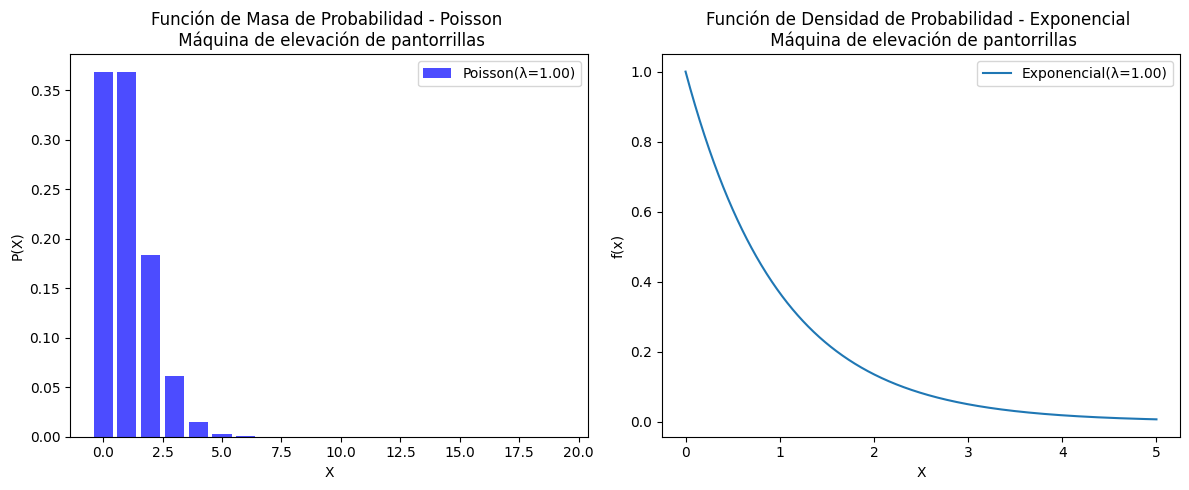

In [43]:
results = pd.DataFrame()

for i, row in maquinas_df.iterrows():
    results = pd.concat([results, simulate_colas(row)],axis=0)

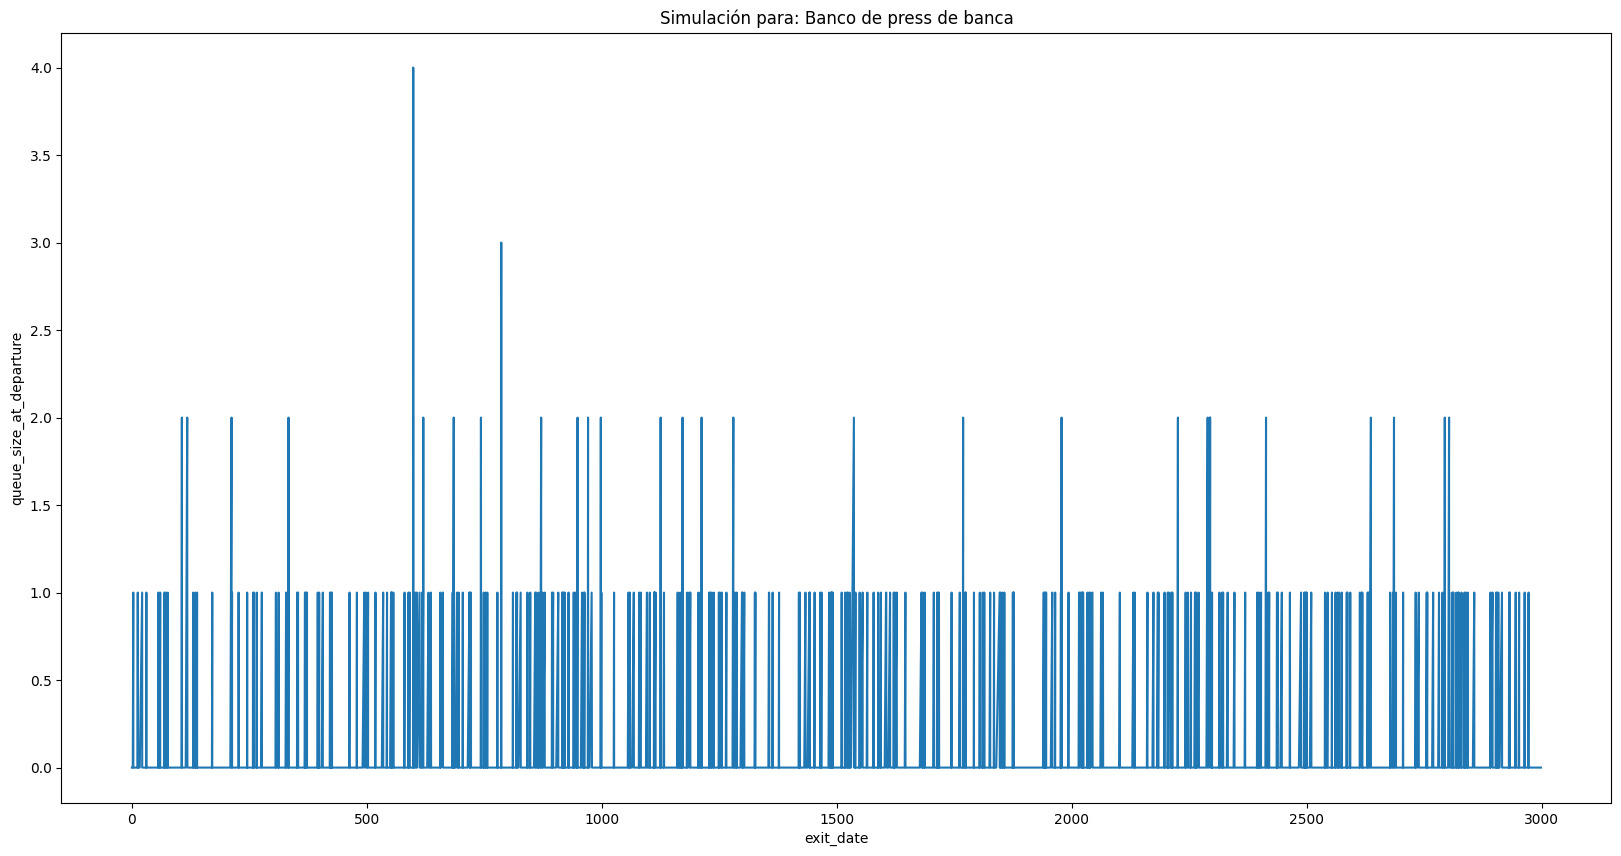

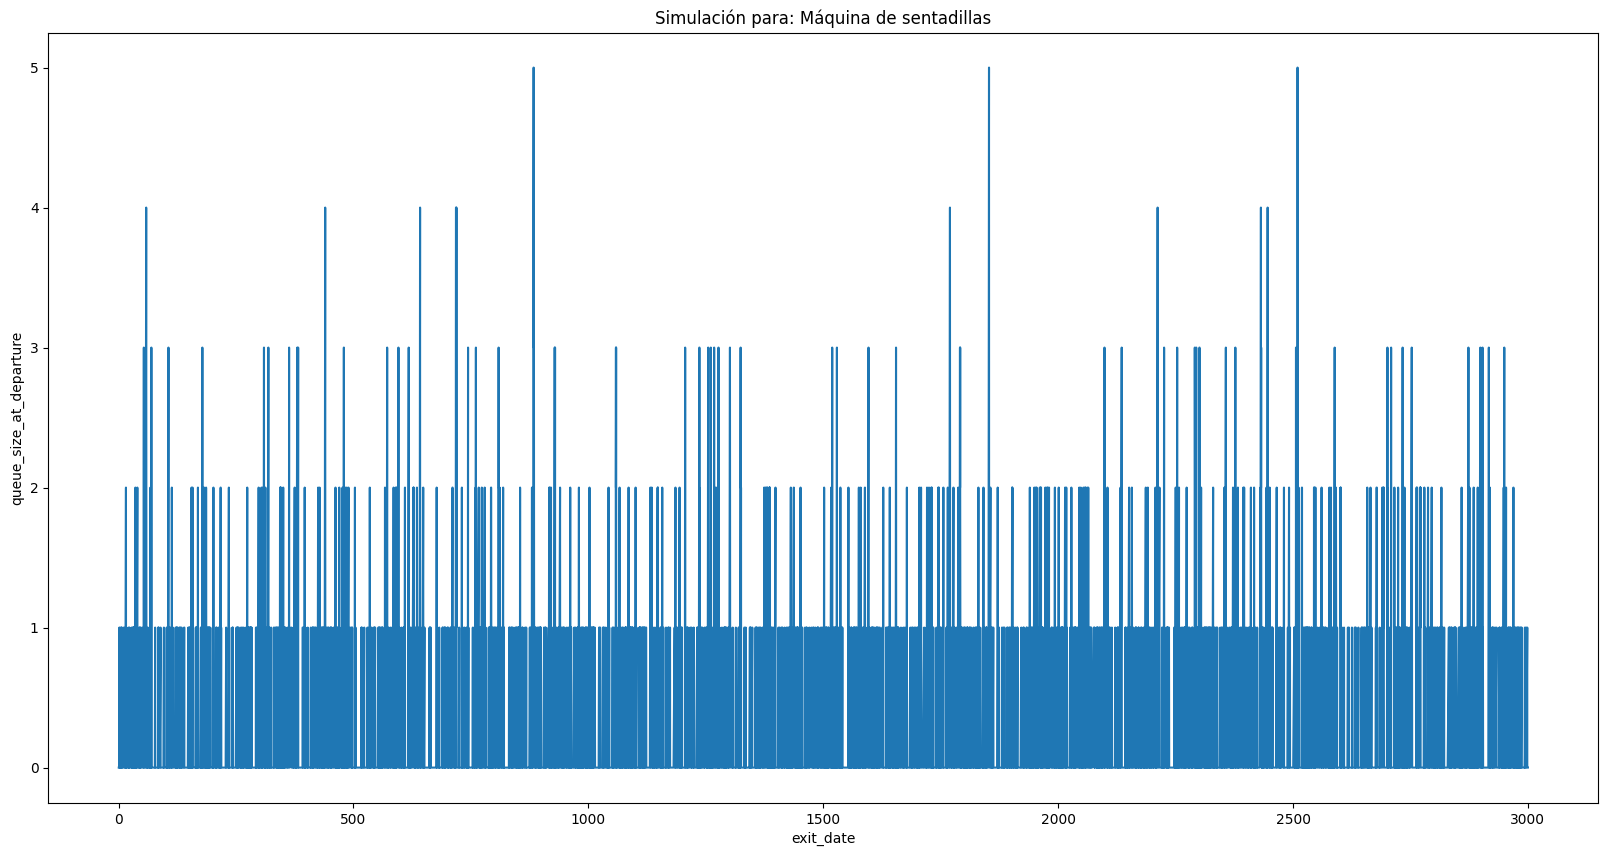

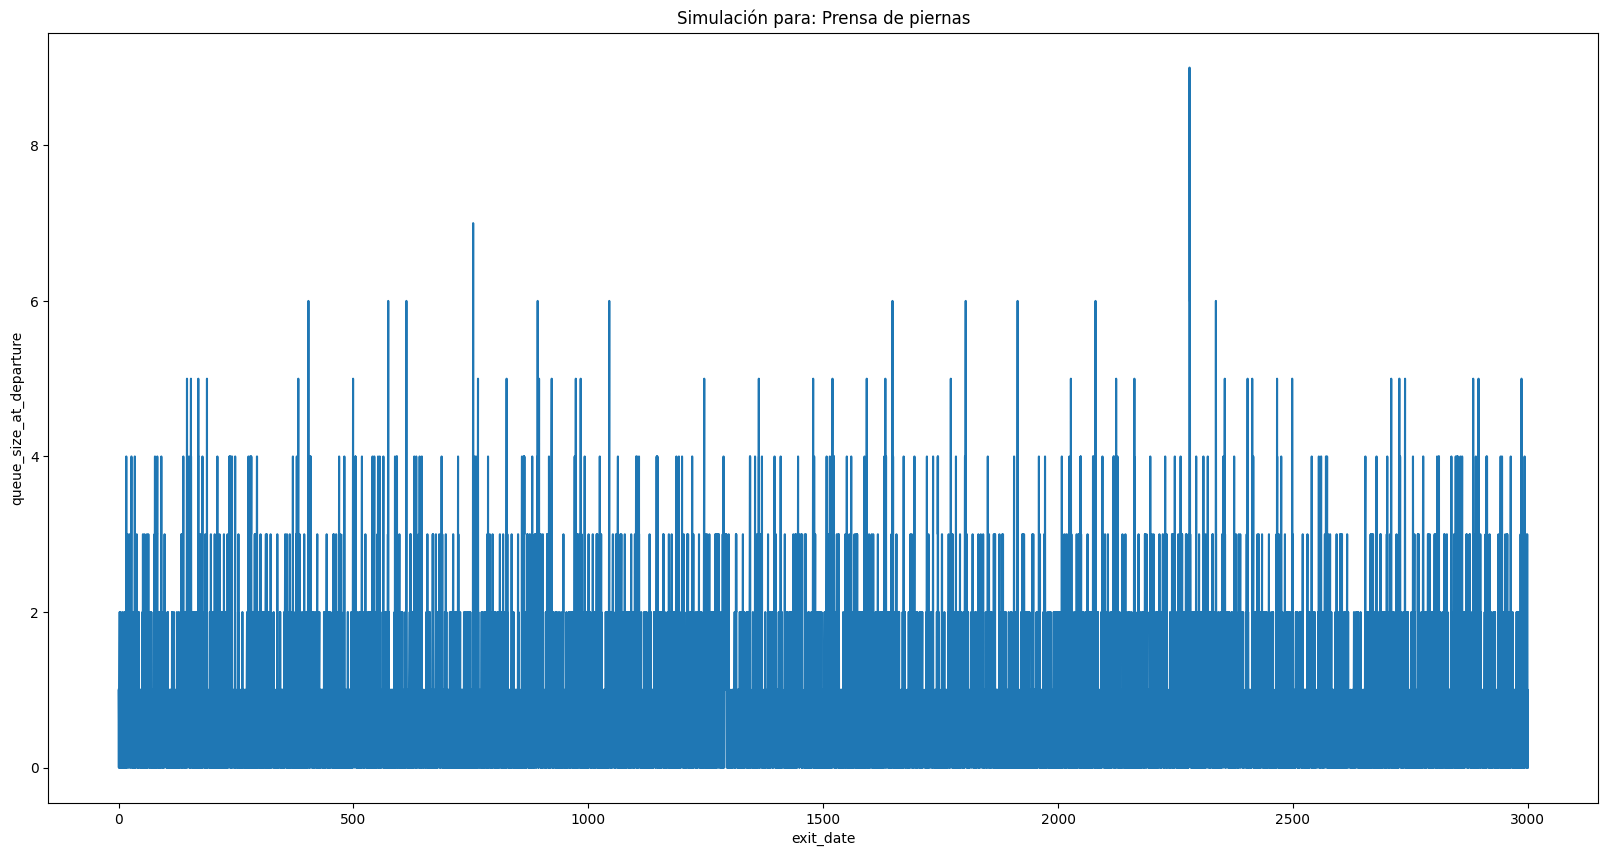

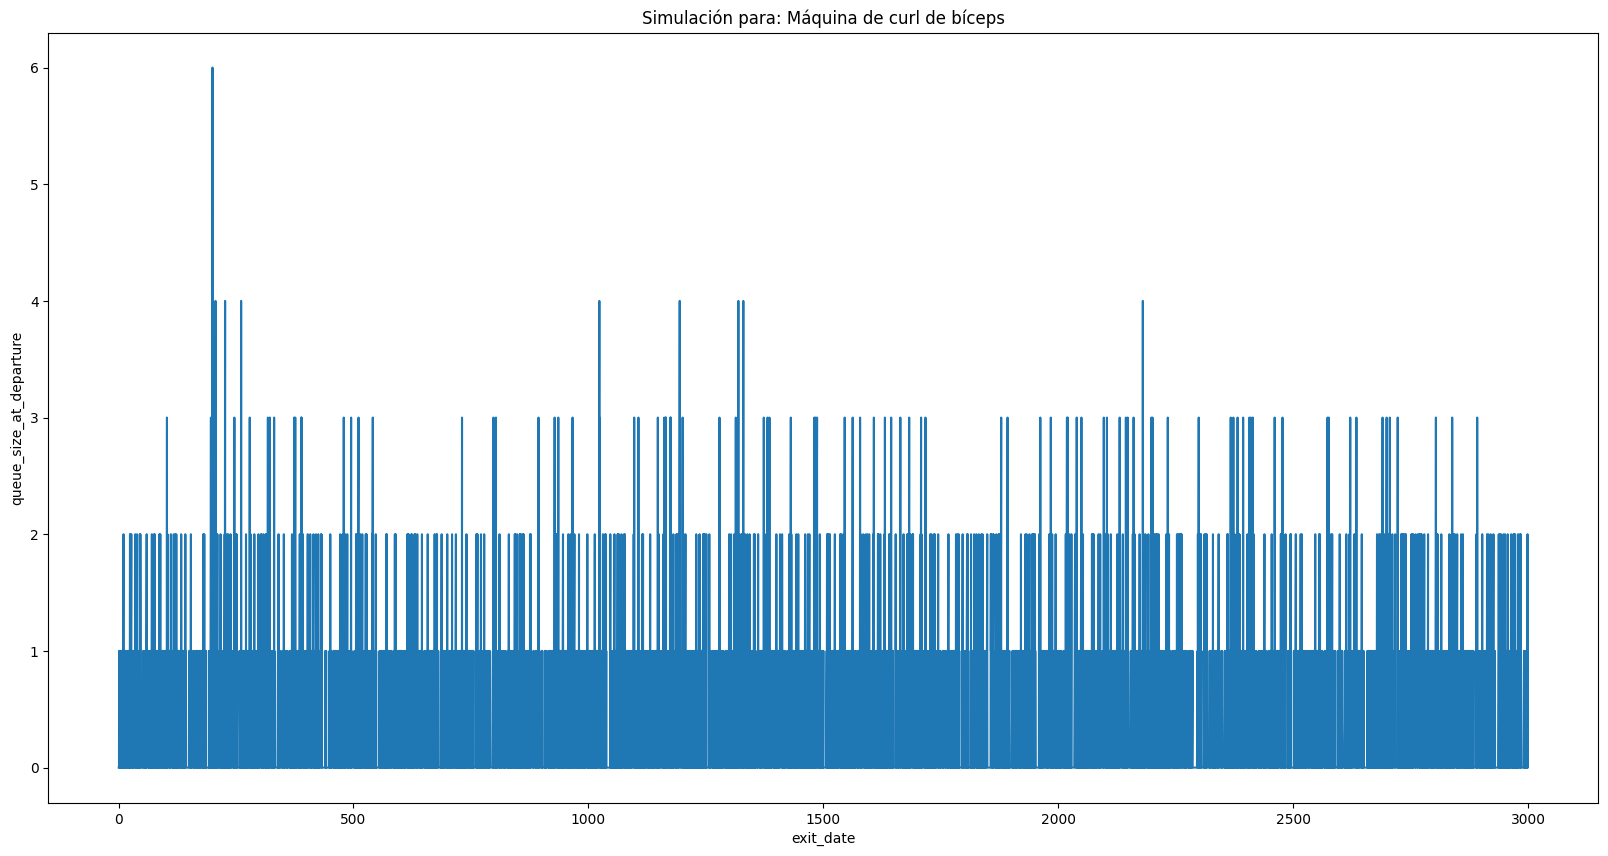

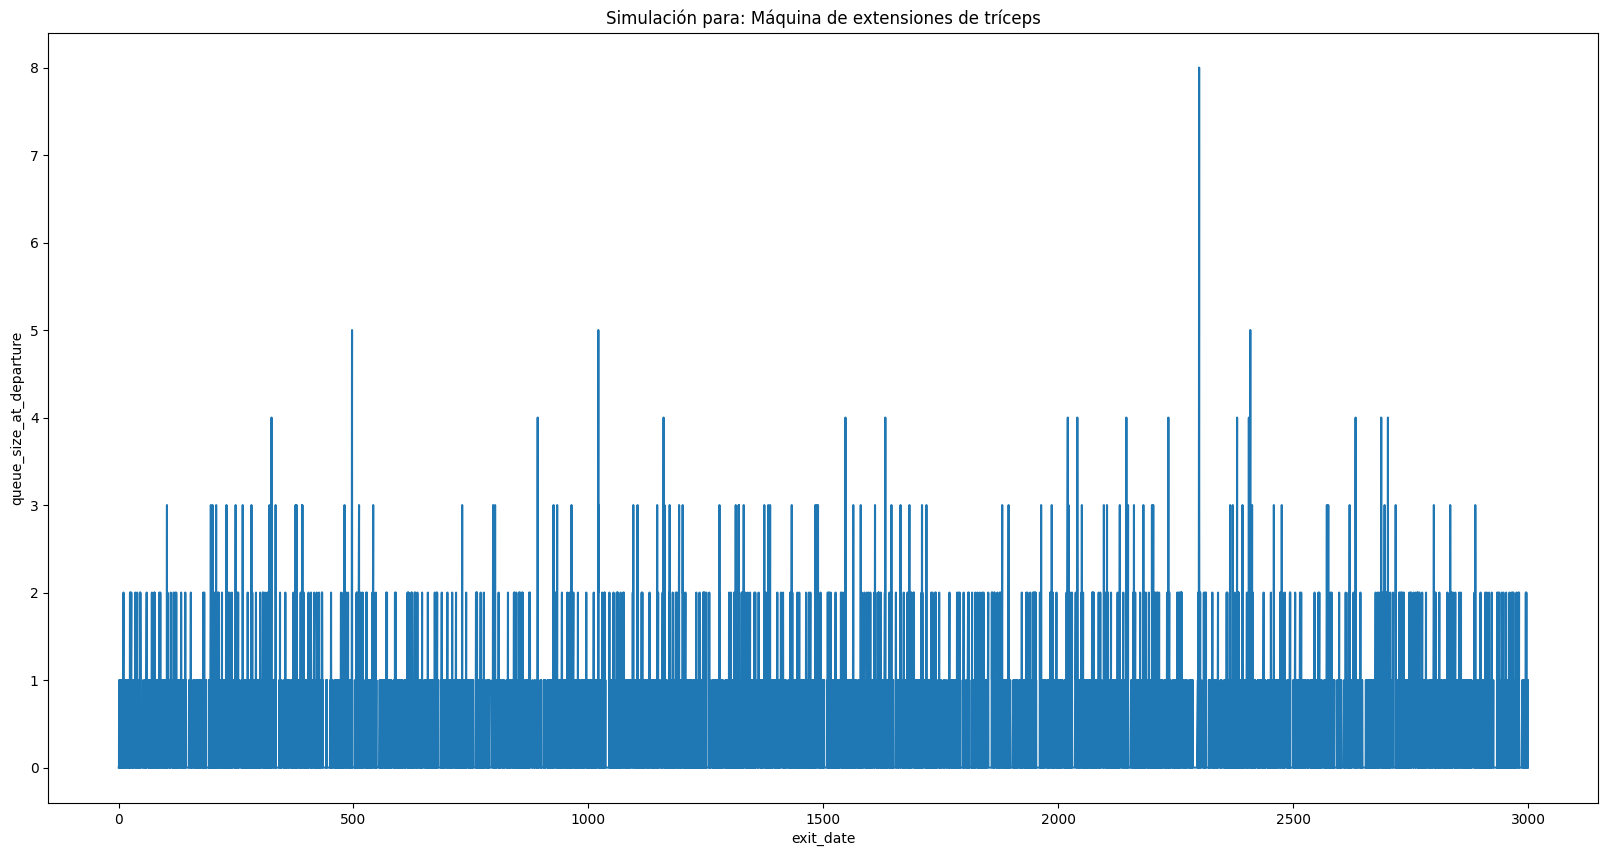

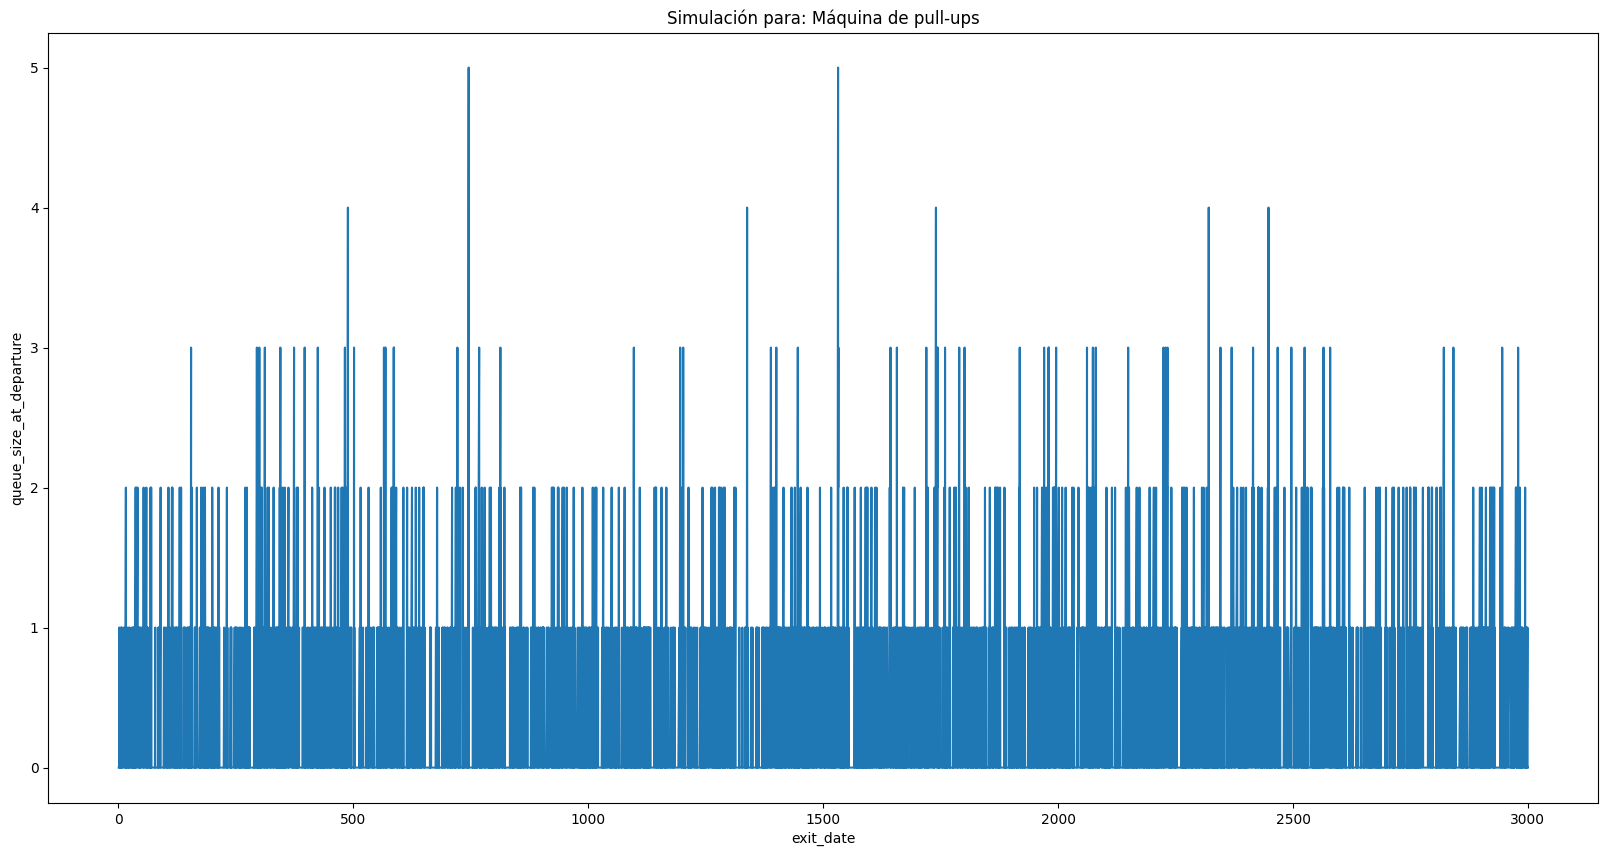

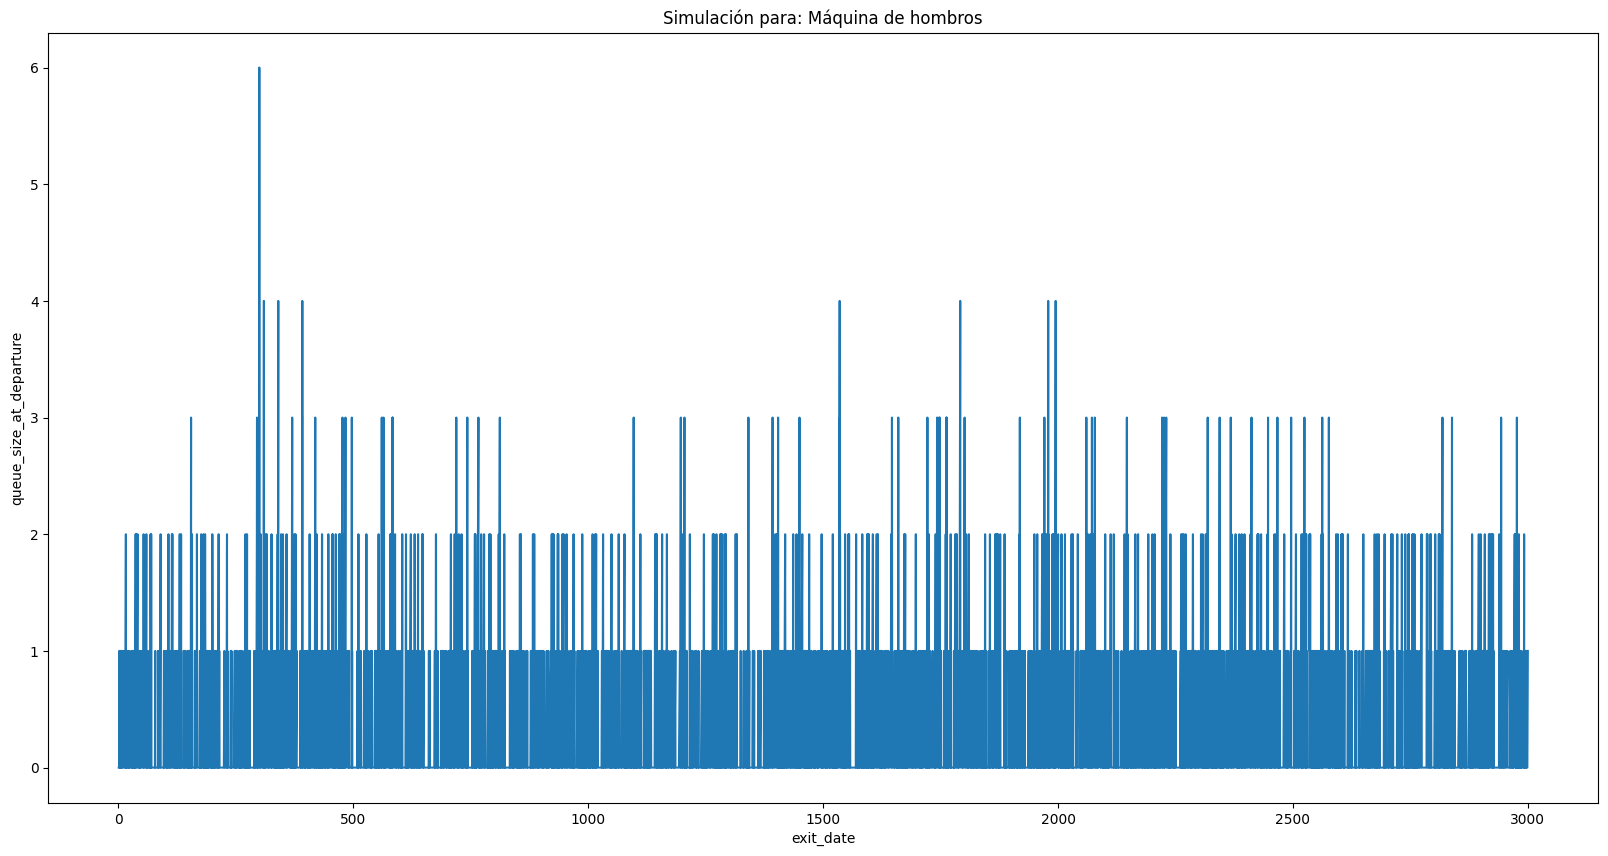

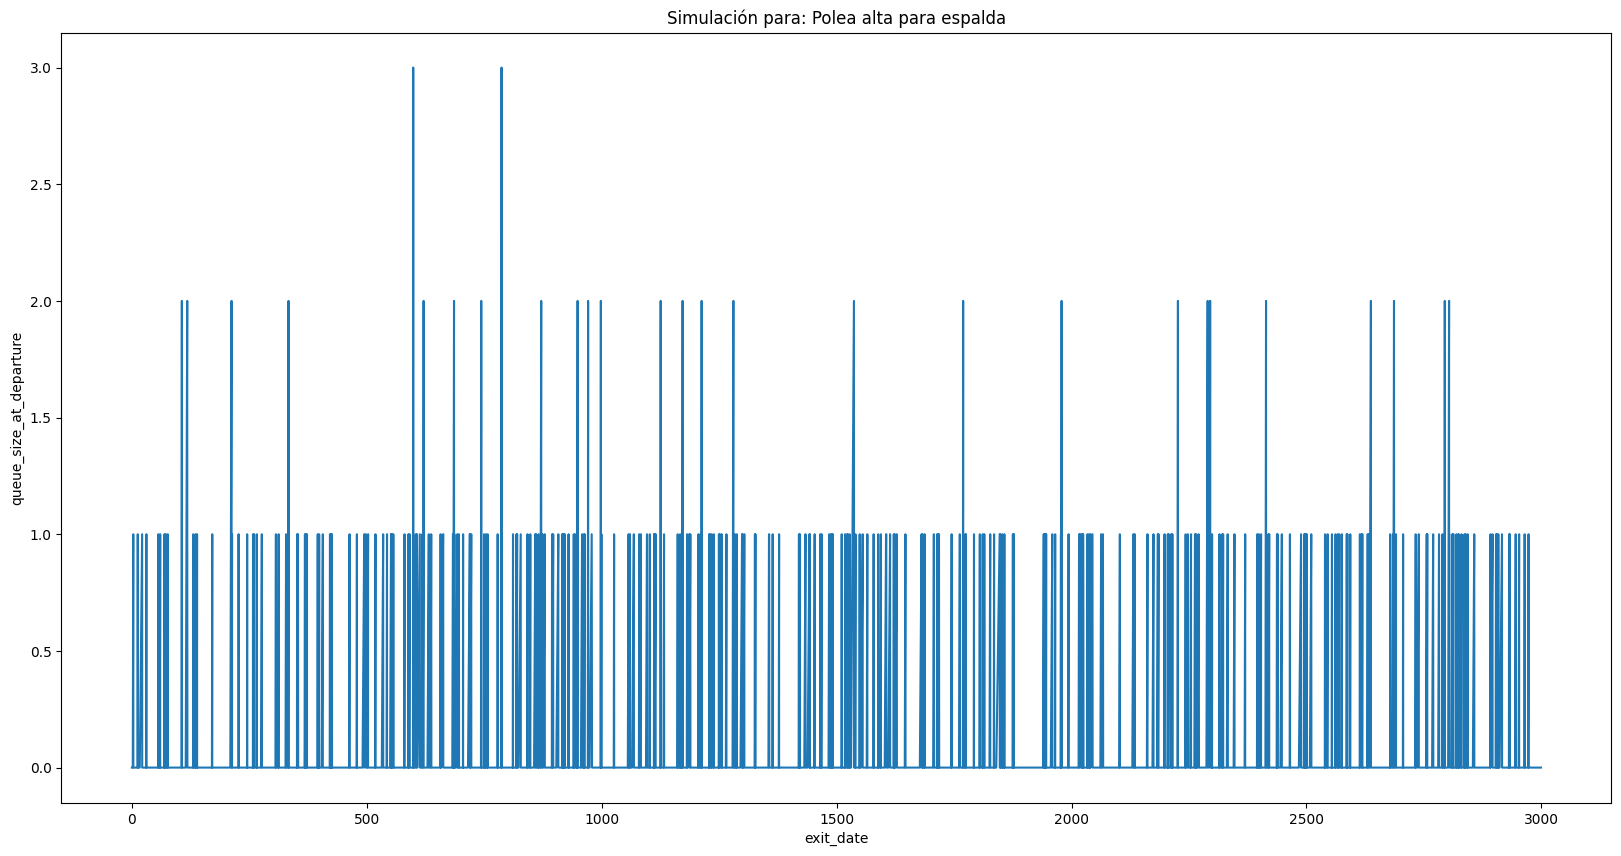

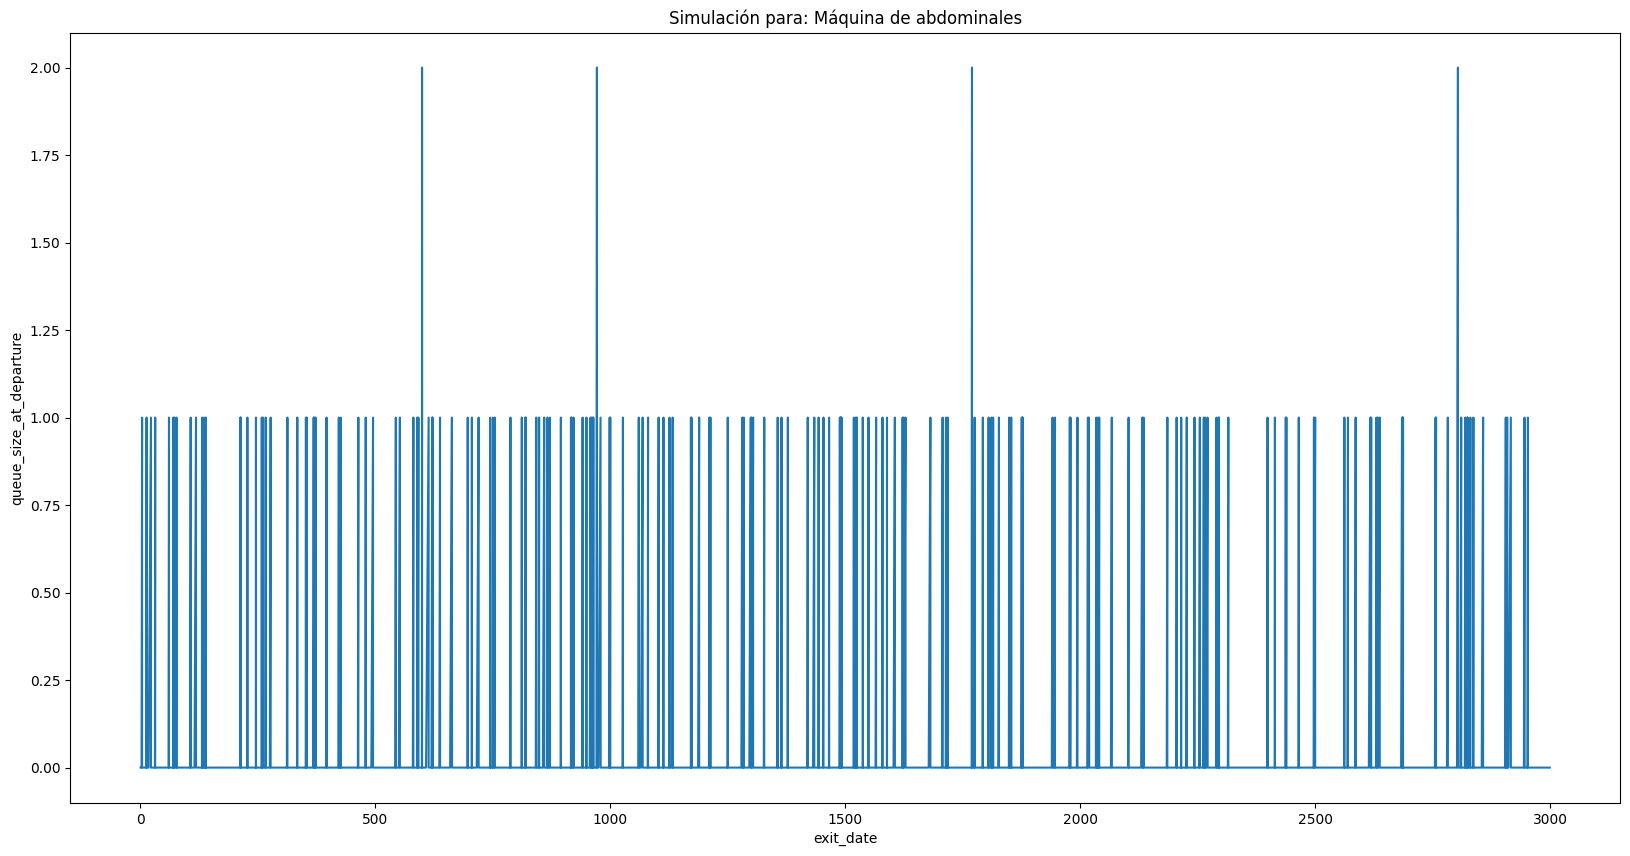

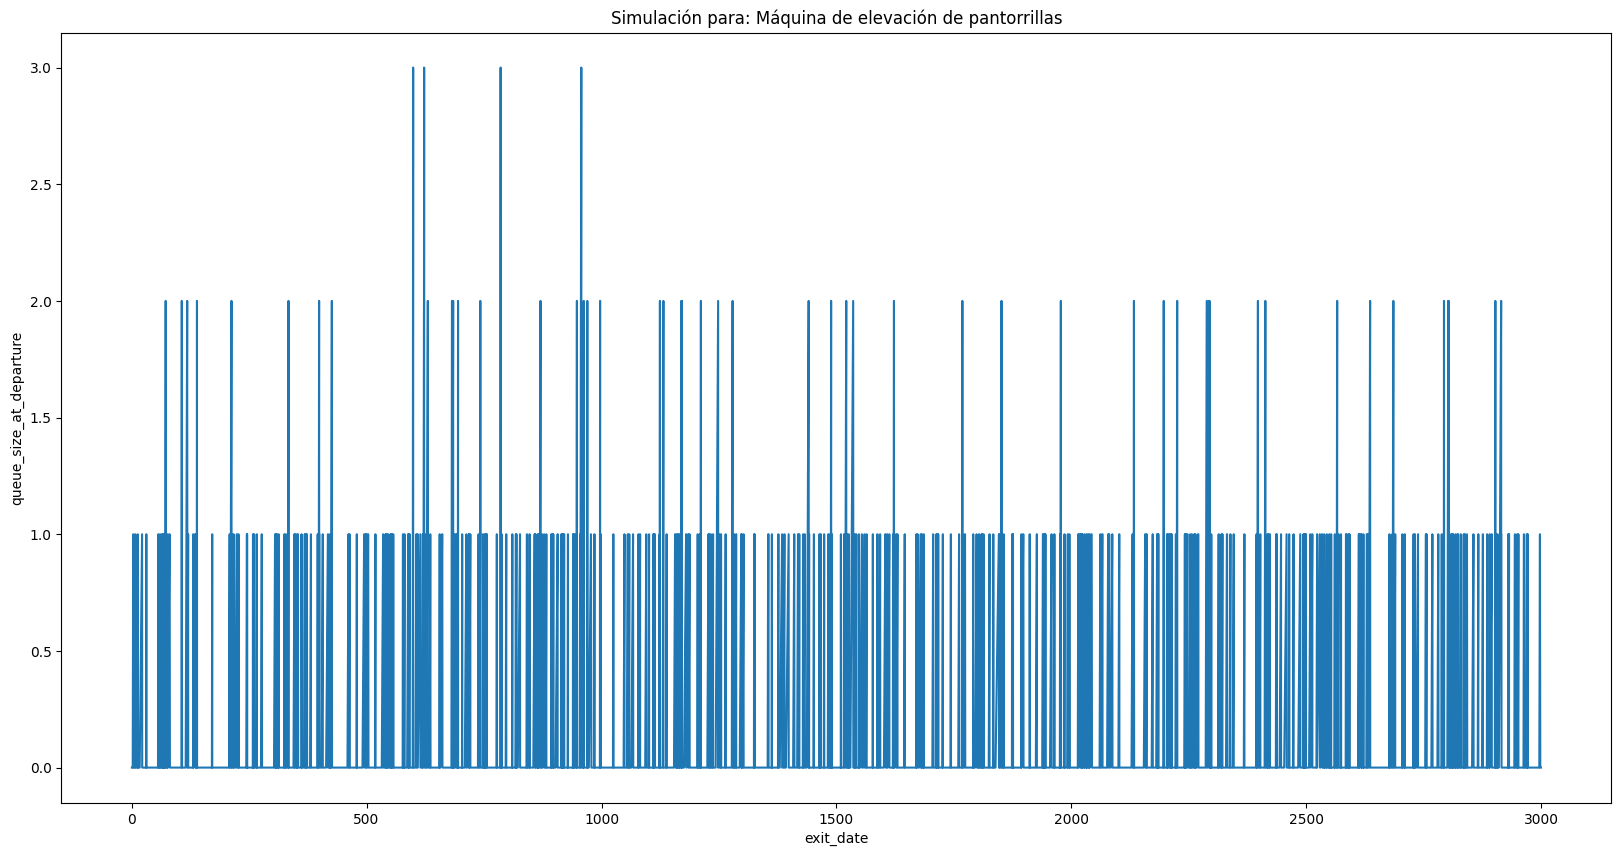

In [20]:

for maquina in maquinas_df['Maquinaria'].values:
    data = results[results['Maquinaria'] == maquina]
    plt.figure(figsize=(20,10))
    plt.title(f'Simulación para: {maquina}')
    sns.lineplot(x=data['exit_date'], y=data['queue_size_at_departure'])
    plt.plot()

,queue_size_at_departure
Maquinaria,
Banco de press de banca,0.152525
Máquina de abdominales,0.074201
Máquina de curl de bíceps,0.489221
Máquina de elevación de pantorrillas,0.223214
Máquina de extensiones de tríceps,0.498486
Máquina de hombros,0.486391
Máquina de pull-ups,0.484526
Máquina de sentadillas,0.446962
Polea alta para espalda,0.151151


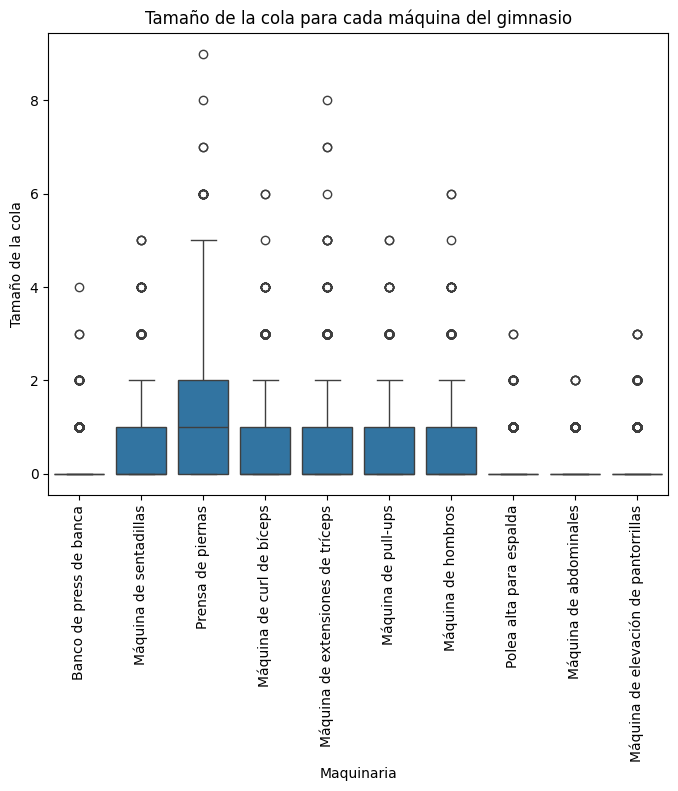

In [5]:
display(results[['Maquinaria', 'queue_size_at_departure']].groupby('Maquinaria').mean())

plt.figure(figsize=(8, 6))
sns.boxplot(x='Maquinaria', y='queue_size_at_departure', data=results)

plt.xlabel('Maquinaria')
plt.ylabel('Tamaño de la cola')
plt.title('Tamaño de la cola para cada máquina del gimnasio')
plt.xticks(rotation=90)

plt.show()

Observamos que la media de usuarios en cada máquina nunca excede las 2 personas; sin embargo, al examinar la distribución mediante el boxplot, identificamos momentos anómalos. En el peor escenario, la prensa registra hasta 8 usuarios simultáneos en el sistema. Por ende, resultaría beneficioso considerar una inversión para aumentar la cantidad de prensas en el gimnasio.